## Create example GTiff
First we download a simple GTiff file containing ndvi data from an openeo provider.

In [1]:
import openeo
import pystac
from datetime import datetime
import rasterio
import rasterio.warp
from rasterio.plot import show

In [2]:
# connection = openeo.connect("https://openeo.vito.be")
connection = openeo.connect("openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [3]:
bbox = {"west": 5.0, "south": 51.2, "east": 5.1, "north": 51.3}
collection = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=bbox,
    temporal_extent=["2021-06-01", "2021-06-30"],
    bands=["B04", "B08", "SCL"],
    max_cloud_cover=95
)
collection = collection.process("mask_scl_dilation", scl_band_name="SCL", data=collection)
collection = collection.ndvi(red="B04",nir="B08", target_band="NDVI-band").filter_bands("NDVI-band")
collection = collection.reduce_temporal("mean")
collection.download("ndvi-file.tiff", format="GTiff")

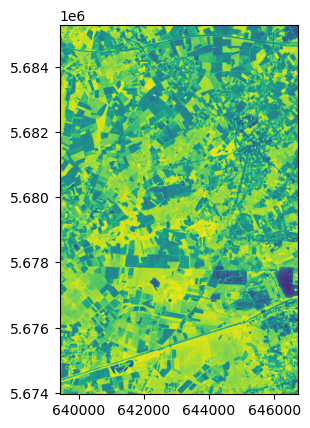

In [4]:
with rasterio.open("ndvi-file.tiff") as src:
    show(src)

## Create a STAC item
We create a STAC item for the GTiff file using pystac.

A STAC item is a JSON file that describes a geospatial dataset. It contains metadata about the dataset, such as the spatial extent, the time range, the bands, and the projection. The STAC item also contains links to the data files in assets.

It is important that the GTiff file is accessible for the openeo backend. This can be done by uploading the file to a cloud storage service like AWS S3 or Google Cloud Storage, or by storing the file in your public directory on a terrascope uservm (when using the openeo.vito.be backend).

In [3]:
# url to the tiff file
tiff_url = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/openeo/load-stac-example/ndvi-file.tiff"

# datetime of the tiff file
dt = datetime.fromisoformat("2021-06-01")

#desired output path for the stac item
output_path = "ndvi-example-stac-item.json"

Make sure the band names are set correctly in the STAC item. In this case the band name is "NDVI-band".
**These band names are required by openeo to identify the bands in the data and name them.**

The other metadata in the stac item are extracted from the GTiff file using rasterio.

In [4]:
with rasterio.open(tiff_url) as src:
    proj_bounds = list(src.bounds)
    left, bottom, right, top = rasterio.warp.transform_bounds(src.crs, "EPSG:4326", *src.bounds)
    item = pystac.Item(
        id="ndvi-example-stac-item",
        geometry={
            "type": "Polygon",
            "coordinates": [[
                [left, bottom],
                [right, bottom],
                [right, top],
                [left, top],
                [left, bottom]
            ]]
        },
        bbox=[left, bottom, right, top],
        datetime= dt,
        properties={ # These properties are optional, but can speed up the loading of the data.
            "proj:epsg": src.crs.to_epsg(),
            "proj:shape": src.shape, # Caveat: this is [height, width] and not [width, height] if you want to set them yourself
            "proj:bbox": proj_bounds,
        },
        stac_extensions=[
            "https://stac-extensions.github.io/eo/v1.1.0/schema.json",
            "https://stac-extensions.github.io/projection/v1.1.0/schema.json",
        ],
        assets={
            "ndvi": pystac.Asset(
                href=tiff_url,
                title="Normalized Difference Vegetation Index",
                extra_fields={
                    "eo:bands": [ # REQUIRED: define the bands in the eo extension for openeo to be able to load it
                        {
                            "name": "NDVI-band",
                        }
                    ],
                }
            )
        }
    )
    item.validate()
    item.save_object(dest_href=output_path, include_self_link=False)

Upload the resulting STAC item to a place where the openeo backend can access it. This can be a cloud storage service or a public directory on a terrascope uservm (when using the openeo.vito.be backend).

## Load the STAC item in openeo as a collection
We load the STAC item in openeo as a collection using `load_stac` and download the result as a GTiff file.

**IMPORTANT**: Make sure the STAC item and the GTiff are accessible for the openeo backend. This can be done by uploading the STAC item to a cloud storage service like AWS S3 or Google Cloud Storage, or by storing the STAC item in your public directory on a terrascope uservm (when using the openeo.vito.be backend).

In [5]:
datacube = connection.load_stac("https://artifactory.vgt.vito.be/artifactory/auxdata-public/openeo/load-stac-example/ndvi-example-stac-item.json")
datacube.download("ndvi-from-stac.tiff", format="GTiff")

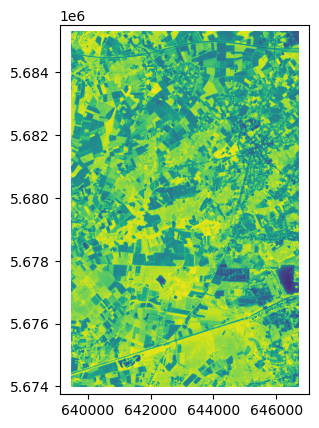

In [6]:
with rasterio.open("ndvi-from-stac.tiff") as src:
    show(src)